# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
import json
import matplotlib.pyplot as plt
import pandas as pd

from collections import defaultdict
from pyspark.sql import SparkSession
from pyspark.sql.functions import * 
from pyspark.sql.types import *
from pyspark.ml import Pipeline 
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler, MinMaxScaler
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator


In [2]:
# create a Spark session
spark = SparkSession.builder.master("local").appName("Sparkify-session").getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
# View the spark dataframe
json_file = spark.read.json("mini_sparkify_event_data.json")
json_file.show()

+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|           page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|      Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|       NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|    Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Bost

Let's have a look at the dataset schema and identify categorical and numeric datatypes

In [4]:
# Get the json file schema
json_file.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



We can count the number of nulls in the dataset to make sure no userIDs or SessionIDs are null. If they are, we may want to remove them.

In [5]:
def null_counts(df, col):
    return df.filter((isnan(df[col])) | (df[col].isNull()) | (df[col] == "")).count()

missing_count = pd.Series([null_counts(json_file, col) for col in json_file.columns], index=json_file.columns)
print(missing_count)


artist           58392
auth                 0
firstName         8346
gender            8346
itemInSession        0
lastName          8346
length           58392
level                0
location          8346
method               0
page                 0
registration      8346
sessionId            0
song             58392
status               0
ts                   0
userAgent         8346
userId            8346
dtype: int64


Removing missing columns from userId and sessionId

In [6]:
df = json_file.dropna(how = "any", subset = ["userId", "sessionId"])
df = df.filter(df["userId"] != "")

In [7]:
# Check number of duplicate columns

df.groupBy(df.columns[0:]).agg(collect_list("userId").alias("id")).where(size("id") > 1).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+---+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId| id|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+---+
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+---+



Get a count of unique users and sessions to get a better understanding of how many participants were a part of this churn study

In [8]:
# unique users and sessions in the data
df.select("userId", "sessionId").distinct().count()

3176

### Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

We can try to understand whether the participants `page` column - which displays their subscription events, have any information for possible churning of customers

In [9]:
df.groupBy('page').count().orderBy('count').show()


+--------------------+------+
|                page| count|
+--------------------+------+
|              Cancel|    52|
|Cancellation Conf...|    52|
|    Submit Downgrade|    63|
|      Submit Upgrade|   159|
|               Error|   252|
|       Save Settings|   310|
|               About|   495|
|             Upgrade|   499|
|                Help|  1454|
|            Settings|  1514|
|           Downgrade|  2055|
|         Thumbs Down|  2546|
|              Logout|  3226|
|         Roll Advert|  3933|
|          Add Friend|  4277|
|     Add to Playlist|  6526|
|                Home| 10082|
|           Thumbs Up| 12551|
|            NextSong|228108|
+--------------------+------+



In [10]:
# number of users with cancellation and cancellation confirmation
df.filter((col('page') == 'Cancellation Confirmation')).groupBy('level').count().orderBy('count').show()


+-----+-----+
|level|count|
+-----+-----+
| free|   21|
| paid|   31|
+-----+-----+



In [11]:
# Create a churned column
churned_customers = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
df = df.withColumn("Churn", churned_customers("page"))

In [12]:
df.filter((col('page') == 'Downgrade')).groupBy('level').count().orderBy('count').show()
potential_churns = udf(lambda x: 1 if x == "Downgrage" else 0, IntegerType())
df = df.withColumn("Potential_churn", potential_churns("page"))

+-----+-----+
|level|count|
+-----+-----+
| paid| 2055|
+-----+-----+



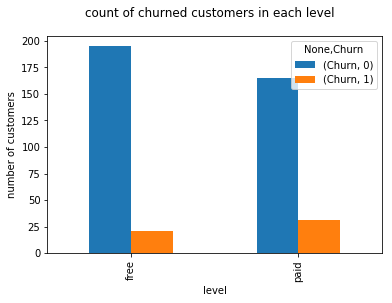

In [13]:
### Visualize if the churned customers were paying or free subscribers

use_level_count = df.groupby('userId', 'level', 'Churn').count()
use_level_count_pd  = use_level_count.select("userId", "level", 'Churn').toPandas()
use_level_count_pd[['level', 'Churn']].groupby(['level', 'Churn']).agg({'Churn':'count'}).unstack().plot(kind='bar')
plt.suptitle('count of churned customers in each level')
plt.ylabel('number of customers');

In [14]:
churned_rate = df.groupby("userId").agg({"Churn": "sum"}).select(avg("sum(Churn)")).collect()[0]["avg(sum(Churn))"]
print("churned: {:.2f}%".format(churned_rate * 100))

churned: 23.11%


# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [15]:
df.select("method").toPandas()['method'].value_counts()

PUT    257818
GET     20336
Name: method, dtype: int64

In [16]:
## Dealing with categorical Features 

df.groupBy('Gender').count().orderBy('count').show()

+------+------+
|Gender| count|
+------+------+
|     M|123576|
|     F|154578|
+------+------+



In [17]:
df.groupBy('song').count().orderBy('count').show()

+--------------------+-----+
|                song|count|
+--------------------+-----+
|I Want A Little S...|    1|
|   Umi De No Jisatsu|    1|
|            Temazcal|    1|
|Remember Who You Are|    1|
|               New E|    1|
|  Noches Reversibles|    1|
|All The Things Sh...|    1|
|  Yo Queria Ser Fiel|    1|
|    The Perfect Year|    1|
|Monosylabik Parts...|    1|
|  The death of music|    1|
|Beggars & Hangers-On|    1|
|Feather in a Base...|    1|
|        This Is Home|    1|
|            On Guard|    1|
|Coral Princess (3...|    1|
|Saor (Free)/News ...|    1|
|          Ingravitto|    1|
|Is It The Skin I'...|    1|
|               Virgo|    1|
+--------------------+-----+
only showing top 20 rows



In [18]:
data_types = defaultdict(list)
for entry in df.schema.fields:
    data_types[str(entry.dataType)].append(entry.name)

ignore = ['artist', 'auth','firstName', 'lastName', 'userId', 'song', 'userAgent']
strings_used = [var for var in data_types["StringType"] if var not in ignore]


In [19]:
data_types

defaultdict(list,
            {'StringType': ['artist',
              'auth',
              'firstName',
              'gender',
              'lastName',
              'level',
              'location',
              'method',
              'page',
              'song',
              'userAgent',
              'userId'],
             'LongType': ['itemInSession',
              'registration',
              'sessionId',
              'status',
              'ts'],
             'DoubleType': ['length'],
             'IntegerType': ['Churn', 'Potential_churn']})

In [20]:
df.agg(*[count(when(isnull(c), c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+-----+---------------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|Churn|Potential_churn|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+-----+---------------+
| 50046|   0|        0|     0|            0|       0| 50046|    0|       0|     0|   0|           0|        0|50046|     0|  0|        0|     0|    0|              0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+-----+---------------+



In [21]:
# get status value counts
df.groupBy('status').count().orderBy('count').show()


# 307: Temporary Redirect
# 404: Not Found
# 200: OK

+------+------+
|status| count|
+------+------+
|   404|   252|
|   307| 23184|
|   200|254718|
+------+------+



In [22]:
### Drop nulls
df = df.dropna(subset=['gender', 'level', 'location', 
                                       'method', 'page', 'status'])

In [23]:

stage_string = [StringIndexer(inputCol= c, outputCol= c+"_string_encoded") for c in strings_used]
stage_one_hot = [OneHotEncoder(inputCol= c+"_string_encoded", outputCol= c+ "_one_hot") for c in strings_used]


# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [24]:
train, temp = df.randomSplit([0.6, 0.4], seed=321)
test, validation = temp.randomSplit([0.8, 0.2], seed=123)

In [25]:
assembler = VectorAssembler(inputCols=['gender_one_hot', 'level_one_hot', 'location_one_hot', 
                                       'method_one_hot', 'page_one_hot', 'status'], outputCol="rawfeatures")

### Using logistic regression for 
# lr =  LogisticRegression(maxIter=10, regParam=0.0, elasticNetParam=0)

In [26]:
minmax = MinMaxScaler(inputCol="rawfeatures", outputCol="features")

In [27]:
pipeline = Pipeline(stages=stage_string+stage_one_hot + [assembler] + [minmax])

In [28]:
lr =  LogisticRegression()
paramGrid = ParamGridBuilder() \
    .addGrid(lr.elasticNetParam,[0.0, 0.1]) \
    .addGrid(lr.regParam,[0.0, 0.1]) \
    .build()

crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=3)

crossval.setSeed(42)

CrossValidator_779d50942799

In [ ]:
features = pipeline.fit(train).transform(train).select('features', 'Churn').withColumnRenamed('Churn', 'label')
features.show()


In [30]:
from time import time
start = time()
cv_model = crossval.fit(features)
end = time()
print('The training process took {} seconds'.format(end - start))

The training process took 126.3337013721466 seconds


In [31]:
valid_features = pipeline.fit(train).transform(validation).select('features', 'Churn').withColumnRenamed('Churn', 'label')
results = cv_model.transform(valid_features)


In [32]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print('Logistic Regression Metrics:')
print('Accuracy: {}'.format(evaluator.evaluate(results, {evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(results, {evaluator.metricName: "f1"})))


Logistic Regression Metrics:
Accuracy: 0.9998635247020289
F-1 Score:0.999840783476364


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.